# Compare and make Predictor of Proliferative outliers

In [22]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import anndata as ad
import scipy


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model

# prediction stuff

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, classification_report,f1_score,PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder



# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [23]:
## parameters
consensus_ov_gene_path = f"{os.getcwd()}/../../data/consensusOV_genes.csv"


exp_id = "all-cellType"
res_id = "cellType" # cellType subtype celltype_granular

curr_treatment = "drug"


pseudobulk_ids = ["GSE192898", "GSE154600", "GSE180661", "GSE217517", "GSE165897"]

tumor_cell_ids = ['Tumor_cell', "Epithelial cells", "Ovarian.cancer.cell",
                  "EOC"]

immune_cell_ids = ['B-cell', 'CD4+_T-cell',  'CD8+_T-cell', 'Macrophage',
                    'Monocyte', 'NK_cell', "CD8+ T-cells", "Macrophages", "Monocytes", 
                    "NK cells", "CD4+ T-cells", "B-cells",
                    "T.cell", "Monocyte", "B.cell", "Immune"]
stromal_cell_ids = ['Endothelial_cell', 'Fibroblast', "Endothelial cells", 
                  "Adipocytes", "Mesangial cells",
                  "Fibroblasts", "Endothelial.cell", "Stromal"]


test_samples = ["Samp_EOC153_primary_Omentum", "SPECTRUM-OV-065_S1_INFRACOLIC_OMENTUM"]



In [24]:
# load each pseudobulk

all_adata = None
for curr_pseudobulk_id in pseudobulk_ids:

    # set file names
    sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell/{curr_pseudobulk_id}_pseudobulks/"
    in_ad_file = f"{sc_aug_data_path}/{exp_id}.h5ad"
    subtype_file = f"{sc_aug_data_path}/{exp_id}_subtypes.tsv"

    # read
    adata = sc.read_h5ad(in_ad_file)
    subtype_df = pd.read_csv(subtype_file, sep="\t")

    # append to obs they should be in exactly the same order
    subtype_df.index = adata.obs.index
    adata.obs = pd.concat([adata.obs, subtype_df], axis=1)

    # make cell type annotations
    if curr_pseudobulk_id == "GSE192898":
        cell_types = ['B-cell',
                        'CD4+_T-cell',
                        'CD8+_T-cell',
                        'Endothelial_cell',
                        'Fibroblast',
                        'Macrophage',
                        'Monocyte',
                        'NK_cell',
                        'Tumor_cell']
    elif curr_pseudobulk_id == "GSE154600":
        cell_types = ["CD8+ T-cells", "Macrophages", "Monocytes", 
                  "NK cells", "CD4+ T-cells", "B-cells", "Endothelial cells", 
                  "Adipocytes", "Mesangial cells",
                  "Fibroblasts", "Epithelial cells"]
    elif curr_pseudobulk_id == "GSE180661":
        cell_types = ["T.cell", "Ovarian.cancer.cell", "Fibroblast", 
                  "Monocyte", "B.cell", "Endothelial.cell", 
                  "Plasma.cell"]
    elif curr_pseudobulk_id == "GSE217517":
        cell_types = ["B cells", "DC", "Macrophages", 
                "Mast cells", "Monocytes", "NK cells", "Plasma cells",
                "T cells", "Endothelial cells", "Fibroblasts",
                "Epithelial cells"]
    elif curr_pseudobulk_id == "GSE165897":
        cell_types = ["EOC", "Stromal", "Immune"]
        

    Y_full = adata.obs[cell_types]
    Y_max = np.copy(Y_full)
    Y_max = np.argmax(Y_max, axis=1)
    Y_max = Y_full.columns[Y_max]
    adata.obs["Y_max"] = Y_max

    adata.obs["GSE_ID"] = curr_pseudobulk_id

    # append
    if all_adata is None:
        all_adata = adata
    else:
        all_adata = ad.concat([all_adata, adata])


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  uti

In [25]:
# set the label

cell_type_vec = np.array(all_adata.obs.subtype)
cell_type_vec[np.where(all_adata.obs.subtype == "PRO")] = "DIF"

idx =  all_adata.obs.sample_id.isin(["ovCHA070", "Samp_EOC372_primary_Peritoneum",
                                                   "Samp_EOC153_primary_Omentum", "Samp_2497",
                                                   "SPECTRUM-OV-083_S1_INFRACOLIC_OMENTUM",
                                                   "SPECTRUM-OV-065_S1_INFRACOLIC_OMENTUM"]) 

idx = np.logical_and(idx, all_adata.obs.Y_max.isin(tumor_cell_ids))
pro_label_idx = np.where(idx)[0]
cell_type_vec[pro_label_idx] = "PRO"

all_adata.obs['subtype_total'] = cell_type_vec

tab = all_adata.obs.groupby(['subtype_total', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
subtype_total,,,,
DIF,22393.0,NaN,NaN,7347.0
IMR,NaN,38342.0,NaN,NaN
MES,NaN,NaN,27709.0,NaN
PRO,13.0,35.0,2.0,1659.0


# Normalize -- BuDDI style

In [26]:
consensus_genes = pd.read_csv(consensus_ov_gene_path)
consensus_genes = np.intersect1d(consensus_genes.gene, adata.var.gene_ids)
adata = adata[:, consensus_genes]



In [27]:
# set up variables and metadata
X_full = all_adata.X
Y_full = all_adata.obs['subtype_total']

gene_df = all_adata.var

meta_df = all_adata.obs
train_vec = np.array(["Train"] * all_adata.obs.shape[0])

idx_train = np.logical_and(all_adata.obs.sample_id.isin(test_samples), all_adata.obs.subtype.isin(["DIFF", "PRO"]))
train_vec[np.where(idx_train)[0]] = "Test"
meta_df["isTraining"] = train_vec

# now seperate out the training and testing data
# for normalization purposes
idx_train = np.where(meta_df.isTraining=="Train")[0] 
X_train = X_full[idx_train]
Y_train = Y_full[idx_train]

## get the top variable genes
#X_colmean = X_train.mean(axis=0)
#X_colvar = X_train.var(axis=0)
#X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))

#idx_top = np.argpartition(X_CoV, -7000)[-7000:]
#gene_df = gene_df.iloc[idx_top]

#X_full = X_full[:,idx_top]
X_full.shape

(97500, 17657)

In [28]:
## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)



# Basic plot

In [29]:
meta_df

,sample_id,stim,isTraining,cell_prop_type,samp_type,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,subtype,Y_max,GSE_ID,subtype_total
0,ovCHA004,CTRL,Train,random,sc_ref,0.028,0.012,0.102,0.858,MES,Endothelial_cell,GSE192898,MES
1,ovCHA004,CTRL,Train,random,sc_ref,0.042,0.072,0.168,0.718,MES,Endothelial_cell,GSE192898,MES
2,ovCHA004,CTRL,Train,random,sc_ref,0.044,0.438,0.286,0.232,DIF,Tumor_cell,GSE192898,DIF
3,ovCHA004,CTRL,Train,random,sc_ref,0.256,0.056,0.054,0.634,MES,CD8+_T-cell,GSE192898,MES
4,ovCHA004,CTRL,Train,random,sc_ref,0.096,0.216,0.104,0.584,MES,Endothelial_cell,GSE192898,MES
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27295,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.646,0.170,0.028,0.156,IMR,Immune,GSE165897,IMR
27296,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.750,0.114,0.028,0.108,IMR,Immune,GSE165897,IMR
27297,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.728,0.176,0.026,0.070,IMR,Immune,GSE165897,IMR
27298,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.766,0.104,0.054,0.076,IMR,Immune,GSE165897,IMR


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.034s...
[t-SNE] Computed neighbors for 10000 samples in 5.539s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.422670
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.521675
[t-SNE] KL divergence after 500 iterations: 1.113877
(10000, 2)
(10000, 2)


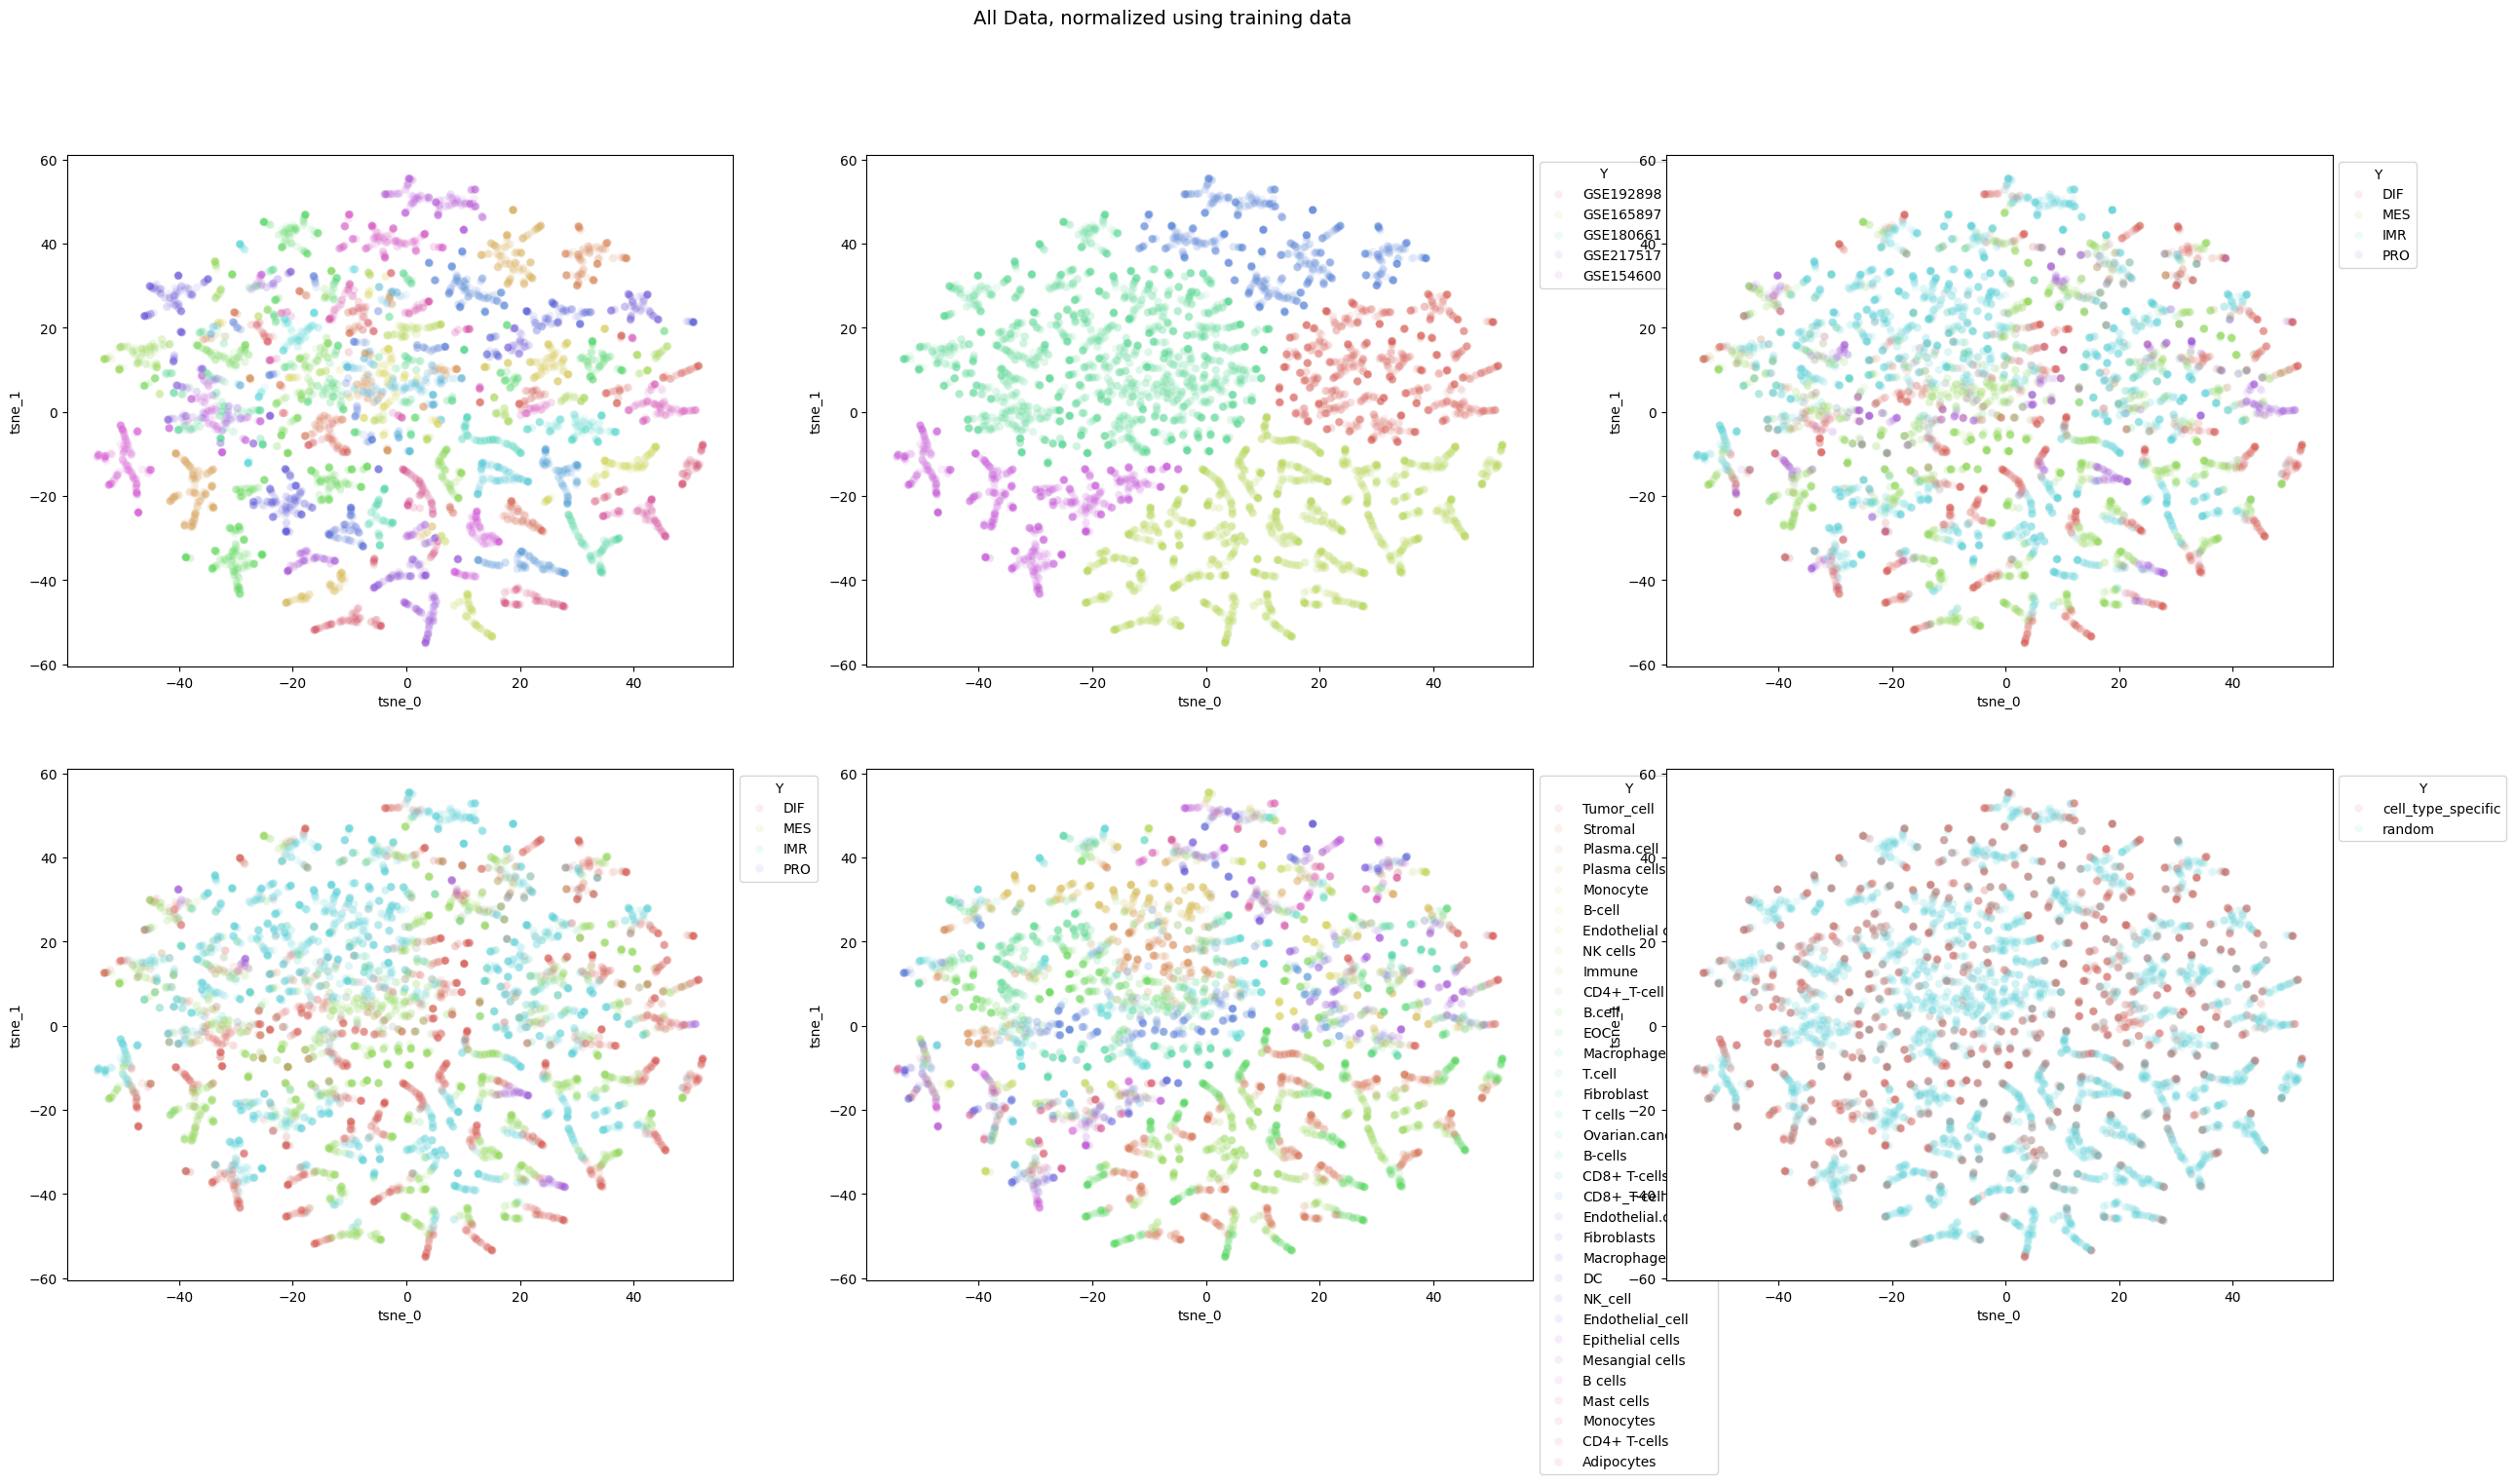

In [9]:
## plot samples
idx_tmp = np.random.choice(range(X_full.shape[0]), 10000, replace=True)


plot_df = vp.get_tsne_for_plotting(X_full[idx_tmp,])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].GSE_ID.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].subtype.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].subtype_total.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].Y_max.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].cell_prop_type.to_numpy(), axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# Make predictions

In [30]:
# make Y numeric 
Y_num = Y_full.astype('category')

# hold out the samples of interest
train_idx = np.where(meta_df.isTraining == "Train")[0]
X_val = X_full[train_idx, :]
Y_val_num = Y_num[train_idx]



X_train, X_test, y_train, y_test = train_test_split(X_val, Y_val_num,
                                                    test_size=0.2,
                                                    random_state = 42,
                                                    stratify = Y_val_num)
len(X_train), len(X_test), len(y_train), len(y_test), set(y_test)


(77294, 19324, 77294, 19324, {'DIF', 'IMR', 'MES', 'PRO'})

In [31]:
final_model = RandomForestClassifier(n_estimators=10, max_features=0.8, max_depth=7)
final_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=0.8, n_estimators=10)

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model_predict = final_model.predict(X_test)
print(classification_report(y_test, model_predict))
print(f1_score(y_test, model_predict, average="weighted"))
print(confusion_matrix(y_test, model_predict))


              precision    recall  f1-score   support

         DIF       0.86      0.86      0.86      5892
         IMR       0.89      0.92      0.91      7669
         MES       0.89      0.86      0.88      5542
         PRO       0.99      0.72      0.84       221

    accuracy                           0.88     19324
   macro avg       0.91      0.84      0.87     19324
weighted avg       0.88      0.88      0.88     19324

0.8837300447086895
[[5059  505  327    1]
 [ 336 7090  243    0]
 [ 411  357 4774    0]
 [  56    4    1  160]]


In [33]:
# use the hold out 
test_idx = np.where(meta_df.isTraining != "Train")[0]
X_heldout = X_full[test_idx, :]
Y_heldout_num = Y_num[test_idx]


model_predict = final_model.predict(X_heldout)
print(classification_report(Y_heldout_num, model_predict))
print(confusion_matrix(Y_heldout_num, model_predict))


              precision    recall  f1-score   support

         DIF       0.19      0.46      0.27       279
         IMR       0.00      0.00      0.00         0
         MES       0.00      0.00      0.00         0
         PRO       1.00      0.01      0.02       603

    accuracy                           0.15       882
   macro avg       0.30      0.12      0.07       882
weighted avg       0.74      0.15      0.10       882

[[129  20 130   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [539  13  46   5]]


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this beh